In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt 

import torch, torch.nn as nn
from torch.nn.utils import weight_norm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.impute import KNNImputer
from sklearn.utils.class_weight import compute_class_weight

In [2]:
#Uncomment below to import files if using google colab

#from google.colab import files
#uploaded = files.upload()

In [3]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

1.13.1
11.6
True


In [4]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3080'

In [5]:
#!ls

In [6]:
df1 = pd.read_csv('train_dynamic_knn_impute_0407.csv')
df2 = pd.read_csv('train_static_0407.csv')
df3 = pd.read_csv('test_dynamic_knn_impute_0407.csv')
df4 = pd.read_csv('test_static_0407.csv')

In [7]:
df1.head(5)

,stay_id,charttime,icu_intime,charttime_hour,charttime_hour_1,charttime_hour_2,charttime_hour_6,charttime_hour_12,charttime_hour_24,calcium,...,chloride,hemoglobin,wbc,alt,ast,alp,bilirubin_total,bilirubin_direct,bilirubin_indirect,pt
0,30004144,2126-04-04 09:30:00,2126-04-04 13:20:25,-3.833333,-4,-2,-1,-1,-1,8.0,...,103,13.0,5.1,29,36,82,0.4,0.7,0.633333,12.5
1,30004144,2126-04-04 13:06:00,2126-04-04 13:20:25,-0.233333,-1,-1,-1,-1,-1,6.8,...,102,11.8,4.8,13,19,90,0.5,0.7,0.566667,13.7
2,30005366,2202-12-28 02:10:00,2202-12-27 17:36:59,8.550000,8,4,1,0,0,8.8,...,100,9.2,9.4,29,18,96,0.5,0.7,0.100000,32.1
3,30006983,2159-10-11 13:20:00,2159-10-12 03:56:42,-14.600000,-15,-8,-3,-2,-1,8.0,...,102,10.1,8.2,44,102,311,8.2,6.9,1.300000,19.8
4,30006983,2159-10-12 04:28:00,2159-10-12 03:56:42,0.516667,0,0,0,0,0,7.1,...,108,10.1,8.2,47,117,278,8.4,6.9,1.300000,21.5


In [8]:
df2.head(5)

,stay_id,icu_intime,vent_start,vent_end,vent_start_hour,vent_end_hour,vent_duration,vent_start_hour_1,vent_end_hour_1,vent_duration_1,...,vent_duration_2,vent_start_hour_6,vent_end_hour_6,vent_duration_6,vent_start_hour_12,vent_end_hour_12,vent_duration_12,vent_start_hour_24,vent_end_hour_24,vent_duration_24
0,30004144,2126-04-04 13:20:25,2126-04-05 16:00:00,2126-04-06 17:00:00,26.650000,51.650000,25.000000,26,51,25,...,12,4,8,4,2,4,2,1,2,1
1,30005366,2202-12-27 17:36:59,2202-12-28 14:00:00,2202-12-28 20:00:00,20.383333,26.383333,6.000000,20,26,6,...,3,3,4,1,1,2,0,0,1,0
2,30006983,2159-10-12 03:56:42,2159-10-12 18:00:00,2159-10-14 19:00:00,14.050000,63.050000,49.000000,14,63,49,...,24,2,10,8,1,5,4,0,2,2
3,30023204,2124-07-09 16:43:55,2124-07-11 16:00:00,2124-07-12 16:10:00,47.266667,71.433333,24.166667,47,71,24,...,12,7,11,4,3,5,2,1,2,1
4,30031418,2156-03-05 14:11:00,2156-03-07 22:06:00,2156-03-08 08:00:00,55.916667,65.816667,9.900000,55,65,10,...,5,9,10,1,4,5,0,2,2,0


In [9]:
df1['stay_id'].value_counts().nlargest(5)

37607624    196
30515259    130
33572547     93
34776632     77
36606626     62
Name: stay_id, dtype: int64

In [10]:
df1['charttime_hour_1'].describe()

count    4220.000000
mean     -244.996445
std       591.332212
min     -3598.000000
25%      -164.000000
50%       -12.000000
75%         3.000000
max        12.000000
Name: charttime_hour_1, dtype: float64

In [11]:
hour_range = [12, 6]
for i in range(9):
    hour_range.append(-i*6)
hour_range = hour_range[::-1]
hour_range

[-48, -42, -36, -30, -24, -18, -12, -6, 0, 6, 12]

In [12]:
def prepX(df, rangelist, impt_col):
    df_copy = df.copy()
    df_drop = df_copy[df_copy['charttime_hour']>=min(rangelist)]
    df_norm = df_drop.copy()
    for col in df_norm.loc[:,'calcium':'pt']:
        if df_norm[col].dtype == 'float64' or df_norm[col].dtype == 'int64':
            df_norm[col] = (df_norm[col]-df_norm[col].mean())/df_norm[col].std()

    nan_array = np.full((10,14),np.nan)
    id_dict = {}
    for index, row in df_norm.iterrows():
        if str(row['stay_id']) not in id_dict:
            id_dict[str(row['stay_id'])] = nan_array.copy()

    for id in id_dict:
        temp_df = df_norm.loc[df_norm['stay_id']==int(id)]
        for i in range(len(rangelist)-1):
            temp_df2 = temp_df.loc[temp_df['charttime_hour'].between(rangelist[i], rangelist[i+1], inclusive = 'left')]
            if not temp_df2.empty:
                temp_df2 = temp_df2.loc[:, impt_col]
                id_dict[id][i] = list(temp_df2.mean())
    #imputer = KNNImputer(n_neighbors=2, weights="distance")
    #imputed = {}
    #empty = []
    for id in id_dict:
        np.nan_to_num(id_dict[id], copy=False)
        
        #imputed[id] = imputer.fit_transform(id_dict[id])
        #if imputed[id].size == 0:
            #empty.append(id)
        
    #for id2 in empty:
        #imputed.pop(id2)
    return id_dict

In [13]:
def prepY(df, X_dict):
    new_df = pd.DataFrame(columns = [df.columns])
    for x in X_dict:
        if int(x) in df['stay_id'].values:
            if new_df.empty:
                new_df = df.loc[df['stay_id']==int(x), :]
            else:
                new_df = pd.concat([new_df, df.loc[df['stay_id']==int(x), :]])
    return new_df

In [14]:
col_to_include = ['calcium', 'creatinine', 'glucose', 
                  'sodium','chloride','hemoglobin','wbc','alt','ast','alp',
                  'bilirubin_total','bilirubin_direct','bilirubin_indirect','pt']

In [15]:
def prepTensors(X_train_dict, df2, X_test_dict, df4, label_col):
    X_train = torch.from_numpy(np.stack(list(X_train_dict.values())))
    y_train = torch.transpose(torch.Tensor([prepY(df2, X_train_dict)[label_col]]), 0, 1)
    print('Length of X and Y train:', len(X_train), len(y_train))
    
    X_test = torch.from_numpy(np.stack(list(X_test_dict.values())))
    y_test = torch.transpose(torch.Tensor([prepY(df4, X_test_dict)[label_col]]), 0, 1)
    print('Length of X and Y test:', len(X_test), len(y_test))
    
    X_train = X_train.float()
    y_train = y_train.float()
    X_test = X_test.float()
    y_test = y_test.float()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    
    return X_train, y_train, X_test, y_test

In [16]:
class sphDataSet(Dataset):
    def __init__(self, input_X, input_y1):
        self.x = input_X
        self.y1 = input_y1
    #    self.y2 = input_y2
        self.n_samples = len(input_y1)

    def __getitem__(self,index):
        return self.x[index], self.y1[index]
        #, self.y2[index]

    def __len__(self):
        return self.n_samples


In [17]:
def prepdataloader(x, y, batchsize):
    train_dataset = sphDataSet(x, y)
    train_dataLoader = DataLoader(train_dataset,
                            batch_size = batchsize,
                            shuffle = True,
                            num_workers=0)
    return train_dataset, train_dataLoader

# TCN Model

In [18]:
'''
TCN source from https://github.com/locuslab/TCN
'''
# removes (k-1) elements from the output on the right. Ensures causality. We first pad and then chomp.
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

# a single temporal layer/block
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)
    
# Create different layers with different dilation sizes
class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [19]:
'''
TCN source from https://github.com/locuslab/TCN
'''

# a TCN model

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, groups, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(groups, num_channels, kernel_size, dropout=dropout)
        self.conv = weight_norm(nn.Conv1d(input_size, groups, kernel_size=1, groups=groups))
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()
#        self.sig = nn.Sigmoid()
#        self.tanh = nn.Tanh()
    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = torch.unsqueeze(x, 2)
        output = self.conv(x)
        output = self.tcn(output)
        #print(output.shape, output)

        output = self.linear(output[:,:,-1])
        #print(output.shape, output)
        return output

# Helper Functions

In [20]:
#function to train and evaluate MSE
def train_evaluate(model, dataloader, dataset, X_test, y_test, epoch, name):
    global lr
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    loss_count = 0 
    loss_init = 0 
    loss_graph = []
    val_errors = []
    for ep in range(epoch):
        model.train()
        running_loss = 0.0
        for x, y in dataloader:
            optimizer.zero_grad()
            output = model(x)
    #        if clip > 0:
    #            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            loss = criterion(output[:,0], y[:,0])
            loss.backward()

            optimizer.step()
            running_loss += loss.item()
        if abs(loss_init- running_loss/len(dataset)) < 0.00001:
            loss_count +=1
        #if loss_count > 10:
            #break
        loss_init = running_loss/len(dataset)
        loss_graph.append(running_loss/len(dataset))

        val_error = 0 
        tp = 0 
        model.eval() 
        output = model(X_test)
        val_error = torch.mean(abs(torch.round(output[:,0]) - y_test[:,0]))
        val_errors.append(val_error.cpu().detach())

        if ep % 50 == 0:
            print(f'[{ep + 1}] loss: {running_loss/len(dataset):.3f}')
            print('Mean L1 error:', val_error)

    model.eval() 
    output = model(X_test)
    output_cpu = output.cpu().detach().numpy().flatten()
    df5[f'{name}']=output_cpu.tolist()
    
    print('Finished Training')
    return loss_graph, output, val_errors

In [21]:
def plotloss(var, str_input, var_list, graph):
    plt.title(f'Loss against epoch ({str_input}, {var})')
    ax = plt.subplot(111)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    #plt.ylim(0, 4)

    for v in var_list:
        num_epochs  = range(len(graph[f'mse__{str_input}_1h_{v}']), )
        plt.plot(num_epochs, graph[f'mse__{str_input}_1h_{v}'], label=f'{v}') 

    ax.legend()

In [22]:
def ploterror(var, str_input, var_list, graph):
    plt.title(f'Mean L1 error against epoch ({str_input}, {var})')
    ax = plt.subplot(111)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')
    #plt.ylim(0, 4)

    for v in var_list:
        num_epochs  = range(len(graph[f'mse__{str_input}_1h_{v}']), )
        plt.plot(num_epochs, graph[f'mse__{str_input}_1h_{v}'], label=f'{v}') 

    ax.legend()

# Training Models

In [23]:
df5 = prepY(df4, prepX(df3, hour_range, col_to_include))

In [24]:
X_train_dict = prepX(df1, hour_range, col_to_include)
X_test_dict = prepX(df3, hour_range, col_to_include)

In [25]:
input_size = 140 #num features * num intervals
groups = 10 #10 time intervals
nhid = 3
level = 10
kernel_size = 3
dropout = 0
lr = 0.001

# Learning Rate

In [26]:
size = 64
output_size = 1
epoch = 101
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_graphs_lr = {}
val_errors_lr = {}

lrs = [0.15, 0.1, 0.01, 0.001, 0.0001, 0.00001]

for lr in lrs:
    print(f'Learning Rate {lr}')
    for str_input in ['start_hour', 'duration']:
        print(f'Starting on {str_input} using MSE loss')
        label_col =  'vent_{}_1'.format(str_input)  
        print(f'Training model for {label_col}')
        X_train, y_train, X_test, y_test = prepTensors(X_train_dict, df2, X_test_dict, df4, label_col)
        train_dataset, train_dataLoader = prepdataloader(X_train, y_train, size)
        model = TCN(input_size, output_size, nhid*[level], groups, kernel_size=kernel_size, dropout=dropout)
        model = model.to(device)
        loss_graph, output, val_errors = train_evaluate(model, train_dataLoader, train_dataset, X_test, 
                                                y_test, epoch, f'mse__{str_input}_1h_{lr}')
        loss_graphs_lr[f'mse__{str_input}_1h_{lr}'] = loss_graph
        val_errors_lr[f'mse__{str_input}_1h_{lr}'] = val_errors
        
        print('=========================')
        print()

Learning Rate 0.15
Starting on start_hour using MSE loss
Training model for vent_start_hour_1
Length of X and Y train: 1206 1206
Length of X and Y test: 513 513
[1] loss: 13.196
Mean L1 error: tensor(24.0526, device='cuda:0', grad_fn=<MeanBackward0>)
[51] loss: 2.340
Mean L1 error: tensor(10.8869, device='cuda:0', grad_fn=<MeanBackward0>)
[101] loss: 2.133
Mean L1 error: tensor(11.0721, device='cuda:0', grad_fn=<MeanBackward0>)
Finished Training

Starting on duration using MSE loss
Training model for vent_duration_1
Length of X and Y train: 1206 1206
Length of X and Y test: 513 513
[1] loss: 25.675
Mean L1 error: tensor(23.7758, device='cuda:0', grad_fn=<MeanBackward0>)
[51] loss: 17.537
Mean L1 error: tensor(27.1969, device='cuda:0', grad_fn=<MeanBackward0>)
[101] loss: 16.885
Mean L1 error: tensor(28.5049, device='cuda:0', grad_fn=<MeanBackward0>)
Finished Training

Learning Rate 0.1
Starting on start_hour using MSE loss
Training model for vent_start_hour_1
Length of X and Y train: 1

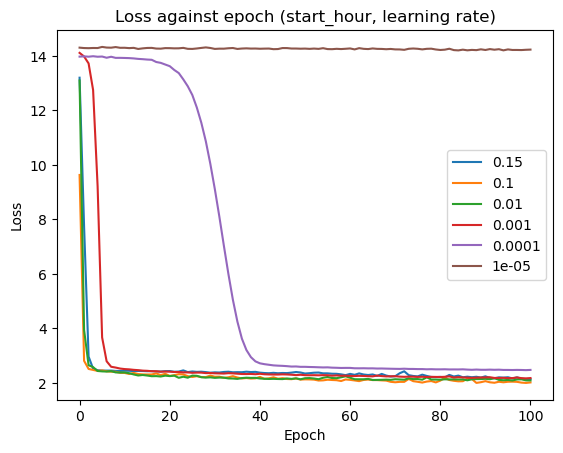

In [27]:
plotloss('learning rate', 'start_hour', lrs, loss_graphs_lr)

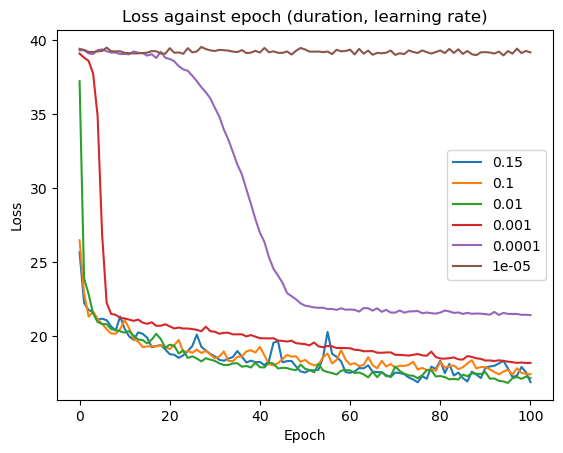

In [28]:
plotloss('learning rate', 'duration', lrs, loss_graphs_lr)

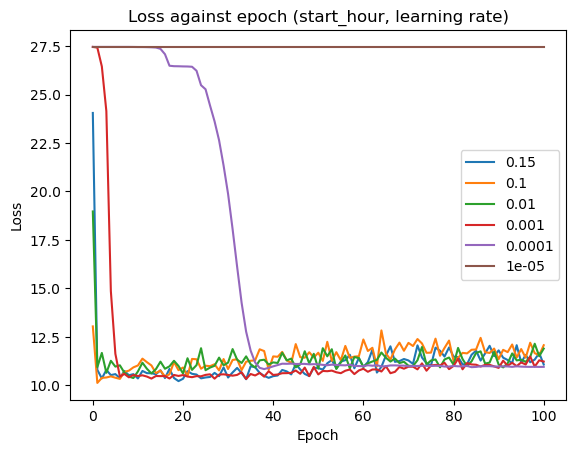

In [29]:
plotloss('learning rate', 'start_hour', lrs, val_errors_lr)

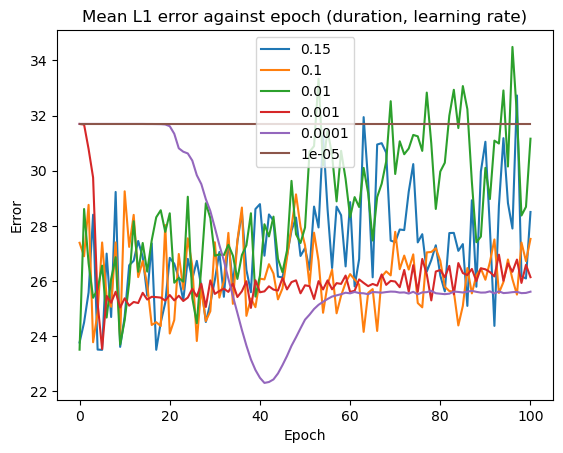

In [30]:
ploterror('learning rate', 'duration', lrs, val_errors_lr)

In [31]:
epoch = 101
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lrs = [0.02, 0.04, 0.06, 0.08]

for lr in lrs:
    print(f'Learning Rate {lr}')
    for str_input in ['start_hour', 'duration']:
        print(f'Starting on {str_input} using MSE loss')
        label_col =  'vent_{}_1'.format(str_input)  
        print(f'Training model for {label_col}')
        X_train, y_train, X_test, y_test = prepTensors(X_train_dict, df2, X_test_dict, df4, label_col)
        train_dataset, train_dataLoader = prepdataloader(X_train, y_train, size)
        model = TCN(input_size, output_size, nhid*[level], groups, kernel_size=kernel_size, dropout=dropout)
        model = model.to(device)
        loss_graph, output, val_errors = train_evaluate(model, train_dataLoader, train_dataset, X_test, 
                                                y_test, epoch, f'mse__{str_input}_1h_{lr}')
        loss_graphs_lr[f'mse__{str_input}_1h_{lr}'] = loss_graph
        val_errors_lr[f'mse__{str_input}_1h_{lr}'] = val_errors
        
        print('=========================')
        print()

Learning Rate 0.02
Starting on start_hour using MSE loss
Training model for vent_start_hour_1
Length of X and Y train: 1206 1206
Length of X and Y test: 513 513
[1] loss: 8.084
Mean L1 error: tensor(10.2066, device='cuda:0', grad_fn=<MeanBackward0>)
[51] loss: 2.273
Mean L1 error: tensor(12.5322, device='cuda:0', grad_fn=<MeanBackward0>)
[101] loss: 1.885
Mean L1 error: tensor(11.6940, device='cuda:0', grad_fn=<MeanBackward0>)
Finished Training

Starting on duration using MSE loss
Training model for vent_duration_1
Length of X and Y train: 1206 1206
Length of X and Y test: 513 513
[1] loss: 31.405
Mean L1 error: tensor(23.0253, device='cuda:0', grad_fn=<MeanBackward0>)
[51] loss: 17.514
Mean L1 error: tensor(26.9415, device='cuda:0', grad_fn=<MeanBackward0>)
[101] loss: 16.325
Mean L1 error: tensor(33.5770, device='cuda:0', grad_fn=<MeanBackward0>)
Finished Training

Learning Rate 0.04
Starting on start_hour using MSE loss
Training model for vent_start_hour_1
Length of X and Y train: 1

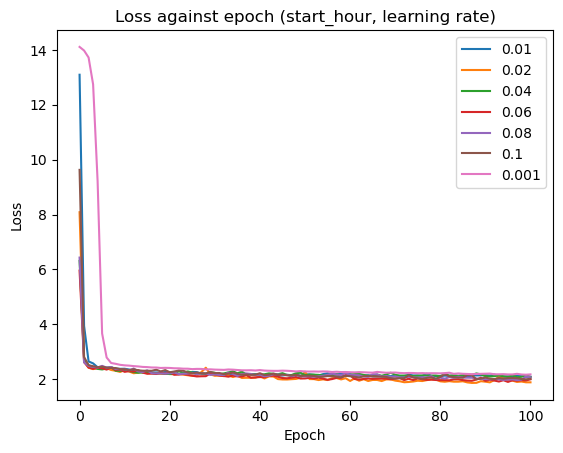

In [32]:
lrs = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.001]
plotloss('learning rate', 'start_hour', lrs, loss_graphs_lr)

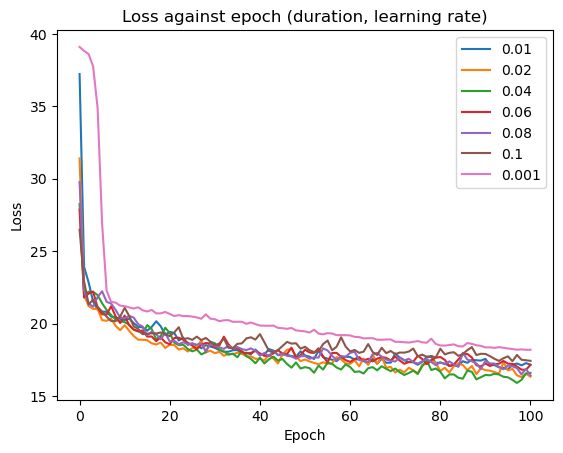

In [33]:
plotloss('learning rate', 'duration', lrs, loss_graphs_lr)

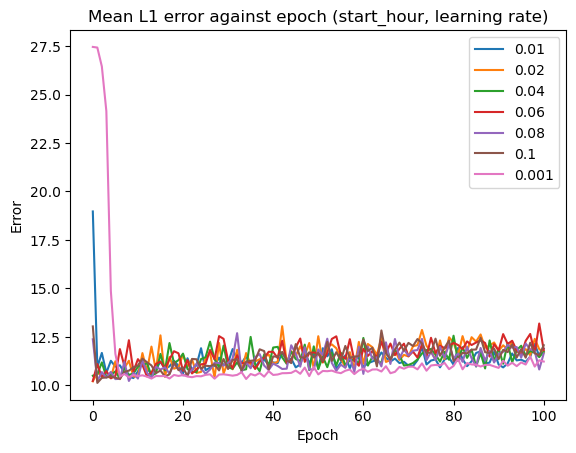

In [34]:
ploterror('learning rate', 'start_hour', lrs, val_errors_lr)

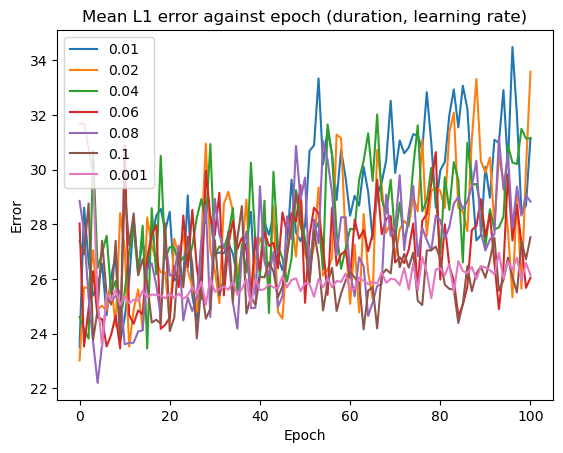

In [35]:
ploterror('learning rate', 'duration', lrs, val_errors_lr)

# Kernel Size

In [36]:
size = 64
output_size = 1
epoch = 101
lr = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_graphs_ks = {}
val_errors_ks = {}

ks = [3, 4, 5, 6]

for kernel_size in ks:
    print(f'Kernel Size {kernel_size}')
    for str_input in ['start_hour', 'duration']:
        print(f'Starting on {str_input} using MSE loss')
        label_col =  'vent_{}_1'.format(str_input)  
        print(f'Training model for {label_col}')
        X_train, y_train, X_test, y_test = prepTensors(X_train_dict, df2, X_test_dict, df4, label_col)
        train_dataset, train_dataLoader = prepdataloader(X_train, y_train, size)
        model = TCN(input_size, output_size, nhid*[level], groups, kernel_size=kernel_size, dropout=dropout)
        model = model.to(device)
        loss_graph, output, val_errors = train_evaluate(model, train_dataLoader, train_dataset, X_test, 
                                                y_test, epoch, f'mse__{str_input}_1h_{kernel_size}')
        loss_graphs_ks[f'mse__{str_input}_1h_{kernel_size}'] = loss_graph
        val_errors_ks[f'mse__{str_input}_1h_{kernel_size}'] = val_errors
        
        print('=========================')
        print()

Kernel Size 3
Starting on start_hour using MSE loss
Training model for vent_start_hour_1
Length of X and Y train: 1206 1206
Length of X and Y test: 513 513
[1] loss: 8.122
Mean L1 error: tensor(10.3977, device='cuda:0', grad_fn=<MeanBackward0>)
[51] loss: 2.068
Mean L1 error: tensor(11.7505, device='cuda:0', grad_fn=<MeanBackward0>)
[101] loss: 1.914
Mean L1 error: tensor(11.7817, device='cuda:0', grad_fn=<MeanBackward0>)
Finished Training

Starting on duration using MSE loss
Training model for vent_duration_1
Length of X and Y train: 1206 1206
Length of X and Y test: 513 513
[1] loss: 27.203
Mean L1 error: tensor(21.9552, device='cuda:0', grad_fn=<MeanBackward0>)
[51] loss: 17.880
Mean L1 error: tensor(32.0721, device='cuda:0', grad_fn=<MeanBackward0>)
[101] loss: 16.985
Mean L1 error: tensor(32.9571, device='cuda:0', grad_fn=<MeanBackward0>)
Finished Training

Kernel Size 4
Starting on start_hour using MSE loss
Training model for vent_start_hour_1
Length of X and Y train: 1206 1206
L

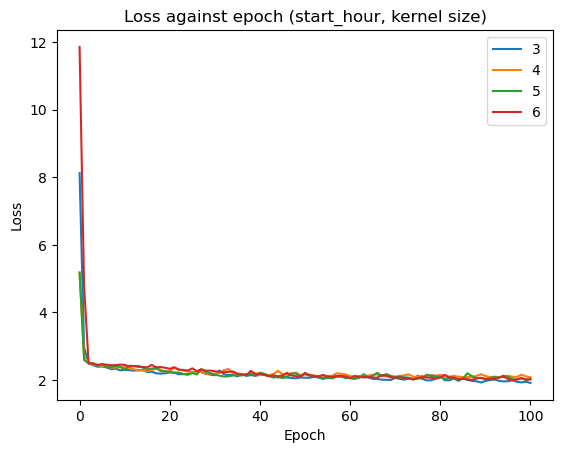

In [37]:
plotloss('kernel size', 'start_hour', ks, loss_graphs_ks)

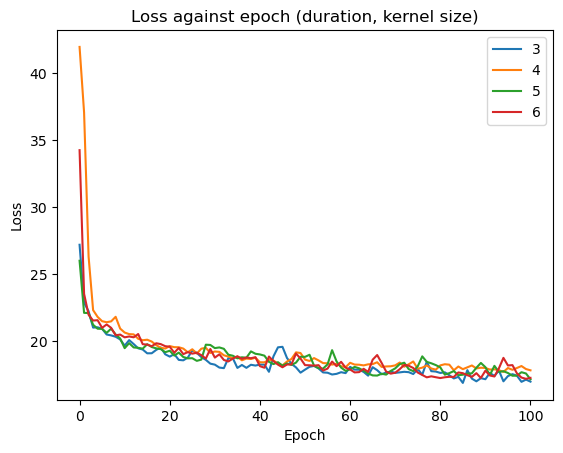

In [38]:
plotloss('kernel size', 'duration', ks, loss_graphs_ks)

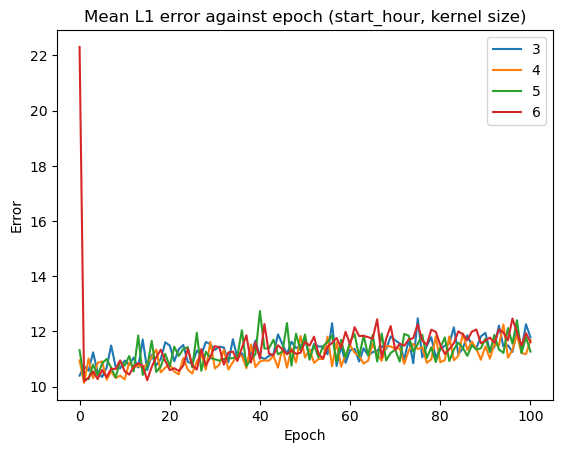

In [39]:
ploterror('kernel size', 'start_hour', ks, val_errors_ks)

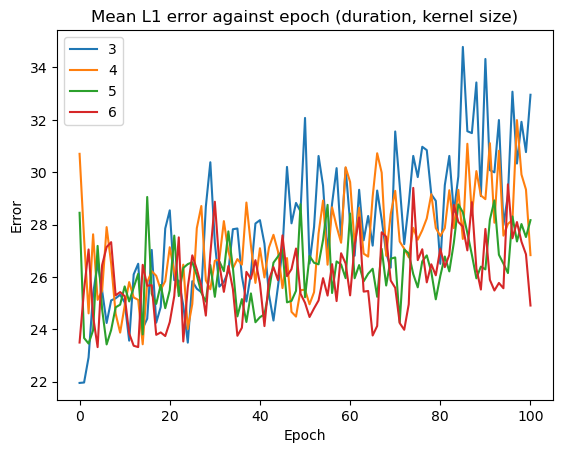

In [40]:
ploterror('kernel size', 'duration', ks, val_errors_ks)

# Dropout

In [41]:
epoch = 101
lr = 0.02
kernel_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_graphs_d = {}
val_errors_d = {}

dropouts = [0, 0.3, 0.4, 0.5, 0.6, 0.7]

for dropout in dropouts:
    print(f'Dropout {dropout}')
    for str_input in ['start_hour', 'duration']:
        print(f'Starting on {str_input} using MSE loss')
        label_col =  'vent_{}_1'.format(str_input)  
        print(f'Training model for {label_col}')
        X_train, y_train, X_test, y_test = prepTensors(X_train_dict, df2, X_test_dict, df4, label_col)
        train_dataset, train_dataLoader = prepdataloader(X_train, y_train, size)
        model = TCN(input_size, output_size, nhid*[level], groups, kernel_size=kernel_size, dropout=dropout)
        model = model.to(device)
        loss_graph, output, val_errors = train_evaluate(model, train_dataLoader, train_dataset, X_test, 
                                                y_test, epoch, f'mse__{str_input}_1h_{dropout}')
        loss_graphs_d[f'mse__{str_input}_1h_{dropout}'] = loss_graph
        val_errors_d[f'mse__{str_input}_1h_{dropout}'] = val_errors
        
        print('=========================')
        print()

Dropout 0
Starting on start_hour using MSE loss
Training model for vent_start_hour_1
Length of X and Y train: 1206 1206
Length of X and Y test: 513 513
[1] loss: 8.106
Mean L1 error: tensor(10.9981, device='cuda:0', grad_fn=<MeanBackward0>)
[51] loss: 2.059
Mean L1 error: tensor(11.0565, device='cuda:0', grad_fn=<MeanBackward0>)
[101] loss: 1.988
Mean L1 error: tensor(11.6043, device='cuda:0', grad_fn=<MeanBackward0>)
Finished Training

Starting on duration using MSE loss
Training model for vent_duration_1
Length of X and Y train: 1206 1206
Length of X and Y test: 513 513
[1] loss: 32.144
Mean L1 error: tensor(24.2573, device='cuda:0', grad_fn=<MeanBackward0>)
[51] loss: 17.863
Mean L1 error: tensor(25.7661, device='cuda:0', grad_fn=<MeanBackward0>)
[101] loss: 16.626
Mean L1 error: tensor(33.2612, device='cuda:0', grad_fn=<MeanBackward0>)
Finished Training

Dropout 0.3
Starting on start_hour using MSE loss
Training model for vent_start_hour_1
Length of X and Y train: 1206 1206
Length 

In [42]:
for dropout in [0]:
    for str_input in ['start_hour', 'duration']:
        print(f'Starting on {str_input} using MSE loss')
        label_col =  'vent_{}_1'.format(str_input)  
        print(f'Training model for {label_col}')
        X_train, y_train, X_test, y_test = prepTensors(X_train_dict, df2, X_test_dict, df4, label_col)
        train_dataset, train_dataLoader = prepdataloader(X_train, y_train, size)
        model = TCN(input_size, output_size, nhid*[level], groups, kernel_size=kernel_size, dropout=dropout)
        model = model.to(device)
        loss_graph, output, val_errors = train_evaluate(model, train_dataLoader, train_dataset, X_test, 
                                                y_test, epoch, f'mse__{str_input}_1h_{dropout}')
        loss_graphs_d[f'mse__{str_input}_1h_{dropout}'] = loss_graph
        val_errors_d[f'mse__{str_input}_1h_{dropout}'] = val_errors
        
        print('=========================')
        print()

Starting on start_hour using MSE loss
Training model for vent_start_hour_1
Length of X and Y train: 1206 1206
Length of X and Y test: 513 513
[1] loss: 9.148
Mean L1 error: tensor(11.3684, device='cuda:0', grad_fn=<MeanBackward0>)
[51] loss: 2.147
Mean L1 error: tensor(11.3002, device='cuda:0', grad_fn=<MeanBackward0>)
[101] loss: 1.822
Mean L1 error: tensor(11.7641, device='cuda:0', grad_fn=<MeanBackward0>)
Finished Training

Starting on duration using MSE loss
Training model for vent_duration_1
Length of X and Y train: 1206 1206
Length of X and Y test: 513 513
[1] loss: 31.013
Mean L1 error: tensor(23.4269, device='cuda:0', grad_fn=<MeanBackward0>)
[51] loss: 17.511
Mean L1 error: tensor(26.5478, device='cuda:0', grad_fn=<MeanBackward0>)
[101] loss: 16.523
Mean L1 error: tensor(25.3567, device='cuda:0', grad_fn=<MeanBackward0>)
Finished Training



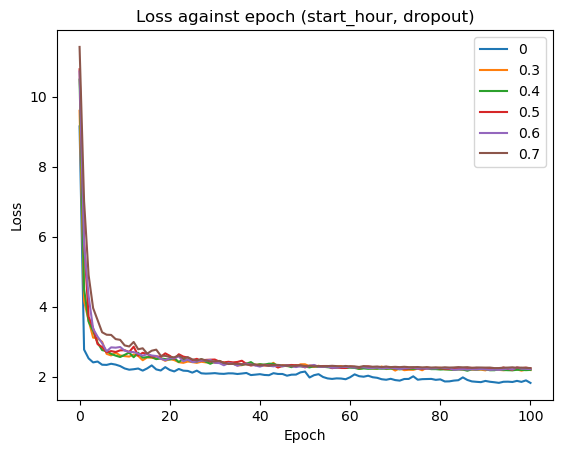

In [43]:
dropouts = [0, 0.3, 0.4, 0.5, 0.6, 0.7]
plotloss('dropout', 'start_hour', dropouts, loss_graphs_d)

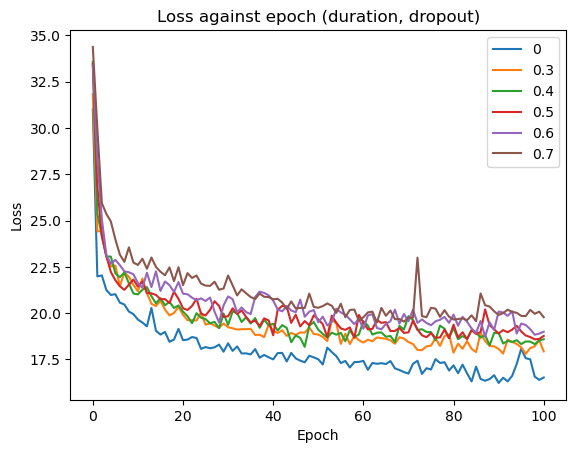

In [44]:
plotloss('dropout', 'duration', dropouts, loss_graphs_d)

(9.0, 15.0)

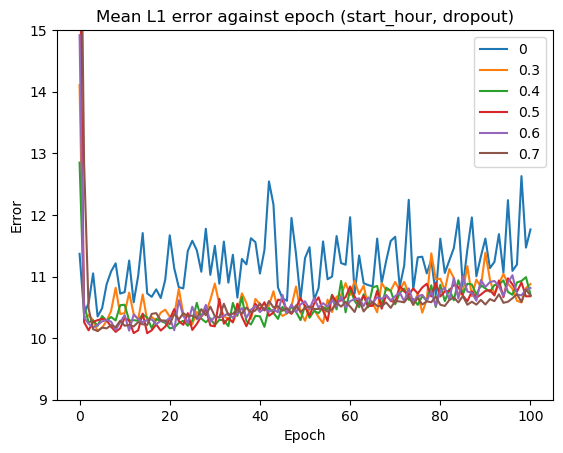

In [45]:
ploterror('dropout', 'start_hour', dropouts, val_errors_d)
plt.ylim(9, 15)

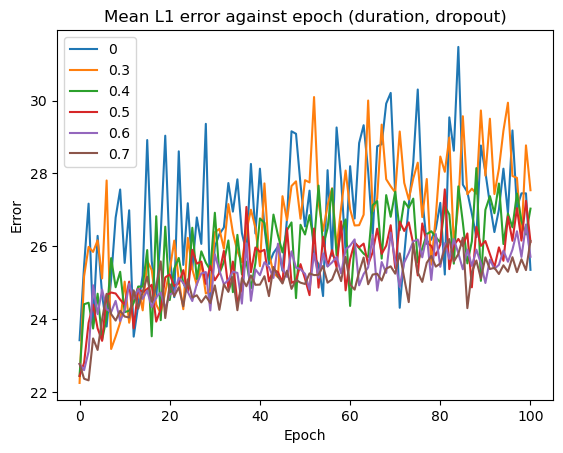

In [46]:
ploterror('dropout', 'duration', dropouts, val_errors_d)

# Hidden Layer

In [47]:
epoch = 101
lr = 0.02
kernel_size = 4
dropout = 0.4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_graphs_nh = {}
val_errors_nh = {}

nh = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for nhid in nh:
    print(f'Hidden Block {nhid}')
    for str_input in ['start_hour', 'duration']:
        print(f'Starting on {str_input} using MSE loss')
        label_col =  'vent_{}_1'.format(str_input)  
        print(f'Training model for {label_col}')
        X_train, y_train, X_test, y_test = prepTensors(X_train_dict, df2, X_test_dict, df4, label_col)
        train_dataset, train_dataLoader = prepdataloader(X_train, y_train, size)
        model = TCN(input_size, output_size, nhid*[level], groups, kernel_size=kernel_size, dropout=dropout)
        model = model.to(device)
        loss_graph, output, val_errors = train_evaluate(model, train_dataLoader, train_dataset, X_test, 
                                                y_test, epoch, f'mse__{str_input}_1h_{nhid}')
        loss_graphs_nh[f'mse__{str_input}_1h_{nhid}'] = loss_graph
        val_errors_nh[f'mse__{str_input}_1h_{nhid}'] = val_errors
        
        print('=========================')
        print()

Hidden Block 1
Starting on start_hour using MSE loss
Training model for vent_start_hour_1
Length of X and Y train: 1206 1206
Length of X and Y test: 513 513
[1] loss: 11.900
Mean L1 error: tensor(14.1384, device='cuda:0', grad_fn=<MeanBackward0>)
[51] loss: 2.242
Mean L1 error: tensor(10.6433, device='cuda:0', grad_fn=<MeanBackward0>)
[101] loss: 2.196
Mean L1 error: tensor(11.2008, device='cuda:0', grad_fn=<MeanBackward0>)
Finished Training

Starting on duration using MSE loss
Training model for vent_duration_1
Length of X and Y train: 1206 1206
Length of X and Y test: 513 513
[1] loss: 37.275
Mean L1 error: tensor(24.6296, device='cuda:0', grad_fn=<MeanBackward0>)
[51] loss: 18.965
Mean L1 error: tensor(26.4464, device='cuda:0', grad_fn=<MeanBackward0>)
[101] loss: 18.580
Mean L1 error: tensor(25.9649, device='cuda:0', grad_fn=<MeanBackward0>)
Finished Training

Hidden Block 2
Starting on start_hour using MSE loss
Training model for vent_start_hour_1
Length of X and Y train: 1206 120

[101] loss: 18.915
Mean L1 error: tensor(27.1423, device='cuda:0', grad_fn=<MeanBackward0>)
Finished Training

Hidden Block 10
Starting on start_hour using MSE loss
Training model for vent_start_hour_1
Length of X and Y train: 1206 1206
Length of X and Y test: 513 513
[1] loss: 7.623
Mean L1 error: tensor(10.1384, device='cuda:0', grad_fn=<MeanBackward0>)
[51] loss: 2.287
Mean L1 error: tensor(10.8363, device='cuda:0', grad_fn=<MeanBackward0>)
[101] loss: 2.238
Mean L1 error: tensor(10.8830, device='cuda:0', grad_fn=<MeanBackward0>)
Finished Training

Starting on duration using MSE loss
Training model for vent_duration_1
Length of X and Y train: 1206 1206
Length of X and Y test: 513 513
[1] loss: 35.126
Mean L1 error: tensor(26.0214, device='cuda:0', grad_fn=<MeanBackward0>)
[51] loss: 19.993
Mean L1 error: tensor(25.6394, device='cuda:0', grad_fn=<MeanBackward0>)
[101] loss: 19.783
Mean L1 error: tensor(24.5926, device='cuda:0', grad_fn=<MeanBackward0>)
Finished Training



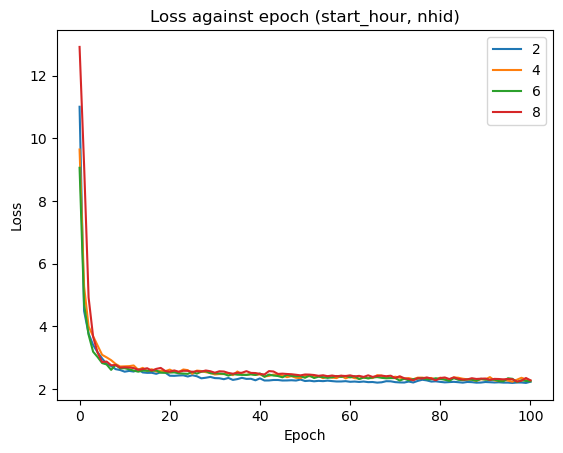

In [48]:
nh = [2, 4, 6, 8]
plotloss('nhid', 'start_hour', nh, loss_graphs_nh)

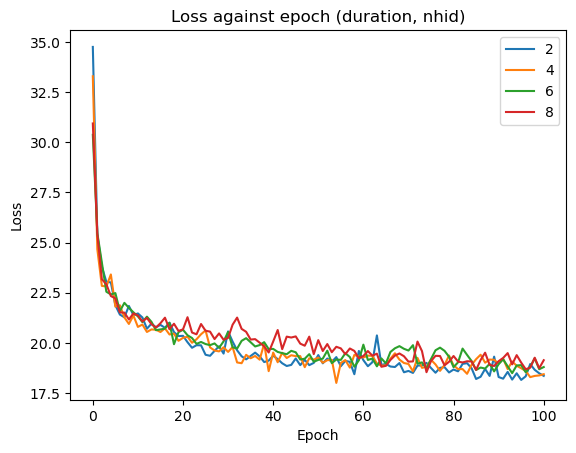

In [49]:
plotloss('nhid', 'duration', nh, loss_graphs_nh)

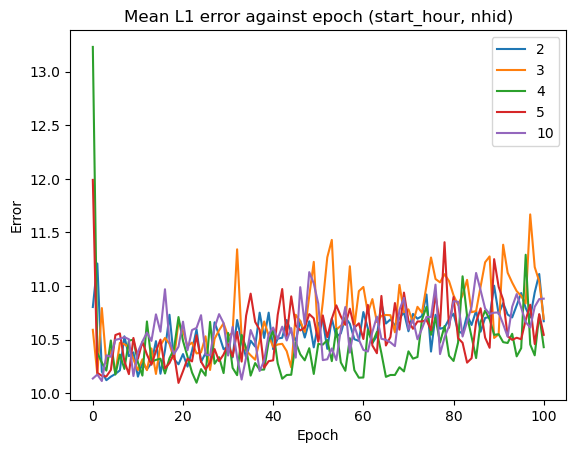

In [50]:
import matplotlib.pyplot as plt 
nh = [2, 3, 4, 5, 10]
ploterror('nhid', 'start_hour', nh, val_errors_nh)

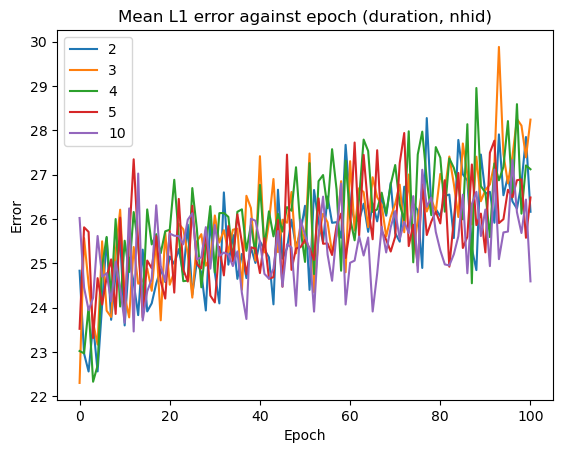

In [51]:
nh = [2, 3, 4, 5, 10]
ploterror('nhid', 'duration', nh, val_errors_nh)

In [54]:
def evaluate_models(str_input , pred):
# str_input should be : start, end, duration 
    df_test_static = df5
    for num_hours in [1, 2, 6, 12, 24]:
        vent_hour_='vent_{}_{}'.format(str_input, num_hours)
        if num_hours==1: 
            labels = df_test_static[vent_hour_]
            L1_abs_err = np.mean(abs(labels - pred))
            print('Mean L1 error:', np.round(L1_abs_err,2))
            MSE = np.mean((labels -pred )**2)
            print('Mean Square error:', np.round(MSE,2))

        output_hours = np.round(pred/num_hours)
        acc_hour = np.sum(output_hours == df_test_static[vent_hour_])/ len(df_test_static)*100
        print('Accuracy at {} hours : {} %'.format(num_hours, np.round(acc_hour,2)))
        
print('===================  VENTILATION START TIME  ============================= ')
evaluate_models('start_hour', df5['mse__start_hour'])

print('===================  VENTILATION DURATION TIME  ============================= ')
evaluate_models('duration', df5['mse__duration'] )

===================  VENTILATION START TIME  ============================= 


KeyError: 'mse__start_hour'

In [71]:
def evaluate_models_24(str_input , pred):
# str_input should be : start, end, duration 
    df_test_static = df5
    for num_hours in [24]:
        vent_hour_='vent_{}_{}'.format(str_input, num_hours)
        if num_hours==1: 
            labels = df_test_static[vent_hour_]
            L1_abs_err = np.mean(abs(labels - pred))
            print('Mean L1 error:', np.round(L1_abs_err,2))
            MSE = np.mean((labels -pred )**2)
            print('Mean Square error:', np.round(MSE,2))

        output_hours = np.round(pred/num_hours)
        acc_hour = np.sum(output_hours == df_test_static[vent_hour_])/ len(df_test_static)*100
        print('Accuracy at {} hours : {} %'.format(num_hours, np.round(acc_hour,2)))

In [72]:
def acc_all(var_list):
    for v in var_list:
        print(f'Variable {v}')
        for str_input in ['start_hour', 'duration']:
            print(f'===================  VENTILATION {str_input}  ============================= ')
            evaluate_models_24(str_input, df5[f'mse__{str_input}_1h_{v}'])
            print()

In [76]:
lrs = [0.15, 0.1, 0.01, 0.001, 0.0001, 0.00001]
ks = [3, 4, 5, 6]
nh = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
dropouts = [0, 0.3, 0.4, 0.5, 0.6, 0.7]

print('Learning Rate')
acc_all(lrs)

print('Kernel Size')
acc_all(ks)

print('Hidden Layer')
acc_all(nh)

print('Dropouts')
acc_all(dropouts)

Learning Rate
Variable 0.15
===================  VENTILATION start_hour  ============================= 
Accuracy at 24 hours : 39.38 %

===================  VENTILATION duration  ============================= 
Accuracy at 24 hours : 17.54 %

Variable 0.1
===================  VENTILATION start_hour  ============================= 
Accuracy at 24 hours : 37.43 %

===================  VENTILATION duration  ============================= 
Accuracy at 24 hours : 17.74 %

Variable 0.01
===================  VENTILATION start_hour  ============================= 
Accuracy at 24 hours : 38.79 %

===================  VENTILATION duration  ============================= 
Accuracy at 24 hours : 15.79 %

Variable 0.001
===================  VENTILATION start_hour  ============================= 
Accuracy at 24 hours : 39.38 %

===================  VENTILATION duration  ============================= 
Accuracy at 24 hours : 16.96 %

Variable 0.0001
===================  VENTILATION start_hour  =============